## Number of fingers classification

In this notebook a small example where number of fingers shown on a hand is calculated. 

The main idea of this notebook is to show the potential of using pretrained models and how these models can be tuned to make another classification task then they where originally trained for.

In this case we use the VGG16 application in Keras and use the weights achived when trained on the Imagenet dataset. This training session takes 2-3 weeks on an average CPU.

Images was collected with a webacam and the aim of the images is to have enough images to make an application with a reasonoble accuracy.

In [16]:
#First load all packages
import numpy as np
import os
import tensorflow as tf

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          fig_size=10):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]*100
    else:
        cm = cm
    

    fig, ax = plt.subplots(figsize=(fig_size,fig_size))
    im = ax.imshow(cm,norm=LogNorm(), cmap=cmap,
                interpolation='nearest')
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ylim=ax.get_ylim()
    ax.set(
        ylim=ylim,
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes, 
        yticklabels=classes,
        title=title,
        ylabel='True label',
        xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
              rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def plot_errors(x_test, y_test, output,n_max=600):
    """ Function the reporting in a script in order to
    breake the script if it is estimated to take to long time"""
    n_not_corr = np.sum(output != y_test )
    n = int(np.ceil(np.sqrt(n_not_corr)))
    j = 0
    if n_not_corr > n_max:
        print('more then '+str(n_max),n**2)
        return
    f, ax = plt.subplots(n, n, figsize=(25, 25))
    ax = ax.flatten()
    
    for i in range(np.shape(output)[0]):
            if output[i]!=y_test[i]:
                ax[j].set_title(str(y_test[i]) + ' as ' + str(output[i]))
                ax[j].imshow(x_test[i,:,:,0], cmap='gray')
                ax[j].axis('off')
                j+=1
    for x in ax.ravel():
        x.axis("off")
    plt.subplots_adjust(bottom=-0.09, wspace=0.03)
    plt.show()

In [6]:
def load_images(folder,N):
    np.random.seed(9001)
    image_folders = os.listdir(folder)
    image_names = os.listdir(folder + image_folders[0])
    number_of_images = 0
    
    for label in image_folders:
        number_of_images += len(os.listdir(folder + label))
    data = np.zeros((N*len(image_folders), 224, 224, 3), dtype='float32')
    
    labels = []
    i = 0
    for label in image_folders:
        im_in_label = os.listdir(folder + label)
        for image_name in im_in_label[:N]:
            img = image.load_img(folder + label + '/' + image_name, target_size=(224, 224))
            img2 = np.array(img)
            img3 = img2 + int(np.random.random()*100-50)
            np.clip(img3, 0, 255,out=img3)
            img3 = img3/255.
            data[i, :, :, :] =img3
            labels.append(label)
            i+=1

    return data, labels

data, data_labels = load_images("./handTracking/Images/",800)#
eval_data, eval_labels = load_images("./handTracking/EvaluationImages/",200)

# Convert labels from strings to numbers
le = preprocessing.LabelEncoder()
le.fit(data_labels)
conv_labels = le.transform(data_labels) 
conv_labels_eval = le.transform(eval_labels)


# Delete images that are just zeros
data = data[0:len(conv_labels), :, :, :]
eval_data = eval_data[0:len(conv_labels_eval), :, :, :]
print('Data is initaly structured in blocks')
print(conv_labels)
# Shuffle the data
conv_labels, data = shuffle(conv_labels, data)
conv_labels_eval, eval_data = shuffle(conv_labels_eval, eval_data)
print('Data after shuffeling')
print(conv_labels)

Data is initaly structured in blocks
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 

### Load a pretrained model
To save some time during the lab we load a pretrained model. The setupThat model setup is included in the bottom of this notebook to show the concept of adding layers to a previously trained model. 

This model adds a few layers on top of the vgg16 model included in Keras. The training cycle afteradding the extra layers took approx 1h.  

In [7]:
# load json and create model
json_file = open('./handTracking/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("./handTracking/model.h5")
print("Loaded model from disk")
loaded_model.summary()

Loaded model from disk
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 

In [8]:
n = 200
pred = loaded_model.predict(data[-n:], batch_size=16)

In [9]:
compare_label = conv_labels[-n:]
pred_lab = np.argmax(pred, axis=1)

In [10]:
pred_eval = loaded_model.predict(eval_data, batch_size=2)
pred_lab_eval = np.argmax(pred_eval, axis=1)

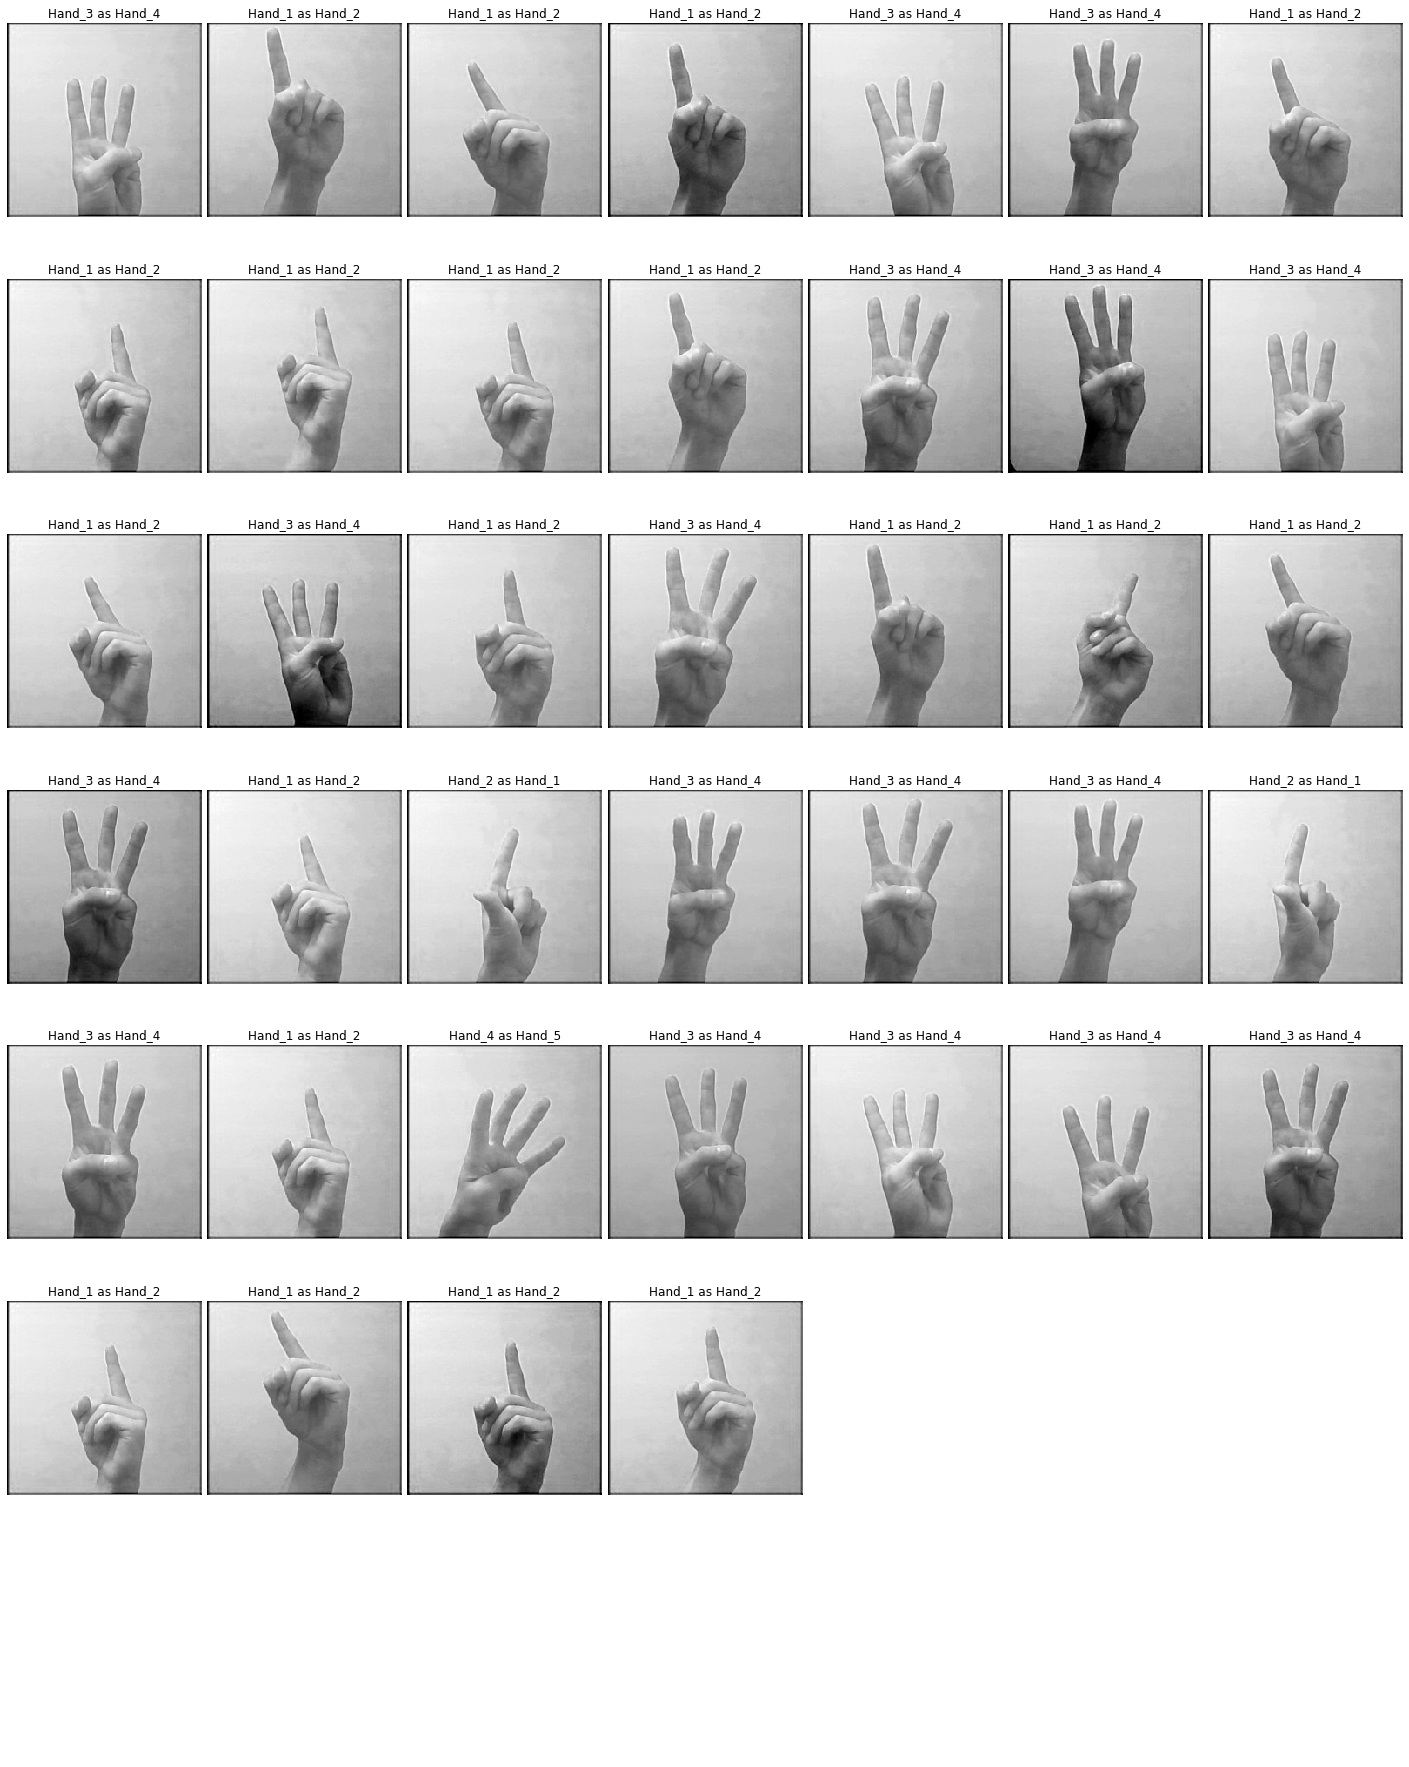

In [12]:
# print(np.shape(eval_data))
plot_errors(eval_data, le.inverse_transform(conv_labels_eval), le.inverse_transform(pred_lab_eval), 600)

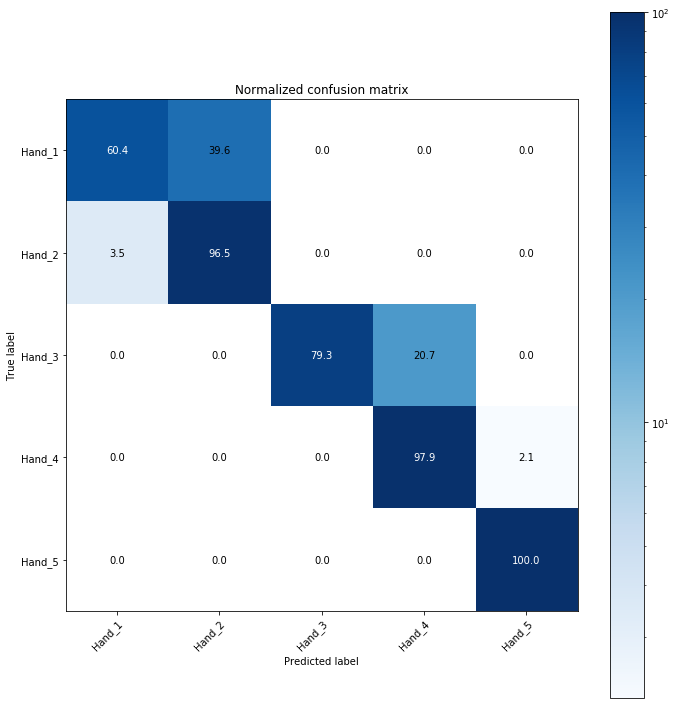

In [17]:
class_names= np.unique(conv_labels_eval)
plot_confusion_matrix(conv_labels_eval, np.argmax(pred_eval, axis=1), classes=le.classes_, normalize=True,
                      title='Normalized confusion matrix',fig_size=10)
plt.show()

In [24]:
conv_labels, data = shuffle(conv_labels, data)
conv_labels_eval, eval_data = shuffle(conv_labels_eval, eval_data)



TypeError: _save_dispatcher() takes from 2 to 4 positional arguments but 5 were given

In [26]:
np.savez('images', data=data, eval_data=eval_data, conv_labels=conv_labels, conv_labels_eval=conv_labels_eval)

# Continue training
Do some further training and see how the prediction changes

In [12]:
# # initialize the number of epochs and batch size
EPOCHS = 1
BS = 16

# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
                        width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
                        horizontal_flip=True, fill_mode="nearest")

loaded_model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=["accuracy"]) 
# Note that 10 epochs takes approx 1,5h....

In [13]:
H = loaded_model.fit_generator(aug.flow(data, conv_labels, batch_size=BS),
                               validation_data=(eval_data , conv_labels_eval), 
                               steps_per_epoch=len(data) // BS,
                               epochs=EPOCHS)

# serialize model to JSON
model_json = loaded_model.to_json()
with open("./handTracking/continued_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
loaded_model.save_weights("./handTracking/continued_model.h5")
print("Saved model to disk")

53/53 [==============================] - 150s 3s/step - loss: 0.4153 - accuracy: 0.8421 - val_loss: 0.2759 - val_accuracy: 0.8694
Saved model to disk


In [14]:
loaded_pred_eval = loaded_model.predict(eval_data, batch_size=2)
loaded_pred_lab_eval = np.argmax(loaded_pred_eval, axis=1)
print(conv_labels_eval)

[4 2 2 1 3 2 1 4 0 0 0 2 0 3 3 2 1 0 0 2 0 2 4 3 0 2 4 2 0 2 2 1 1 3 3 2 2
 3 0 0 2 2 1 4 3 2 4 1 3 2 3 1 4 2 3 0 2 2 2 4 4 4 0 0 3 4 0 0 2 3 2 1 4 1
 2 2 3 1 1 2 2 0 4 4 0 4 0 0 2 4 4 3 2 0 1 2 3 1 3 1 2 4 4 4 1 3 4 1 1 2 2
 3 4 2 2 4 2 4 2 4 0 2 0 0 2 3 1 1 1 4 1 4 4 1 4 4 2 2 1 1 3 2 0 1 4 3 2 3
 1 2 4 1 1 0 0 2 2 1 4 1 0 1 1 4 2 2 1 1 3 3 2 4 1 0 2 1 1 4 4 3 1 2 3 0 4
 1 2 2 2 4 2 3 3 1 0 3 4 1 0 1 2 2 2 4 3 2 1 1 3 4 0 0 3 3 1 0 0 2 3 3 1 1
 2 1 4 3 4 3 2 0 4 0 4 3 4 4 2 1 4 4 3 2 3 2 2 4 2 3 0 2 2 3 1 4 0 1 2 0 4
 1 3 0 2 2 2 3 1 1 4 1 1 2 2 2 0 4 2 3 0 2 4 2 3 0 2 0 2 2 0 0 4]


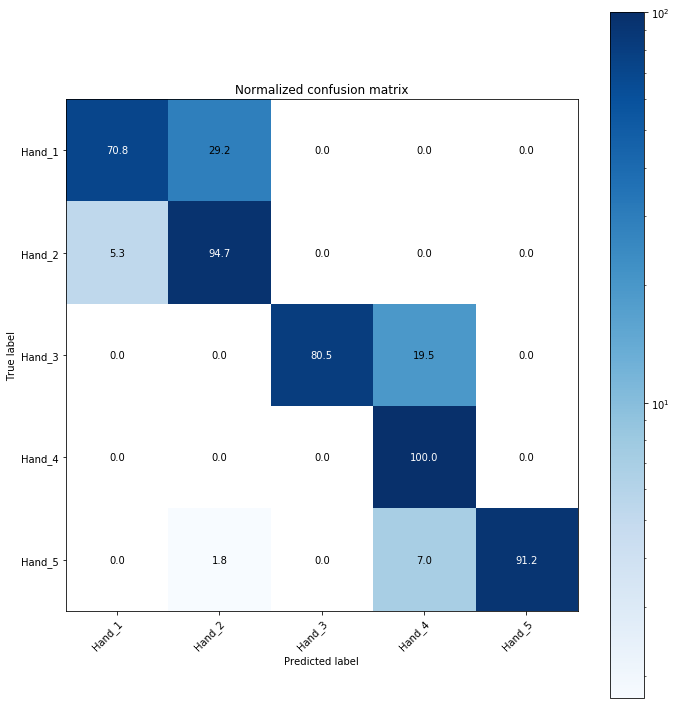

In [15]:
class_names= np.unique(conv_labels_eval)
plot_confusion_matrix(conv_labels_eval, np.argmax(loaded_pred_eval, axis=1), classes=le.classes_, normalize=True,
                      title='Normalized confusion matrix',fig_size=10)
plt.show()

# Building on top of VGG16 model
In this notebook we have loaded a previously trained model. The procedure of loading a trained model and adding layers to that model is described in the cell below.

Working with complex deep learning classification tasks of images without using a previusly trained model is a good way of wasting time. Training the VGG16 model takes a few weeks on an ordinary computer while loading it takes a few seconds.  

In [ ]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off

vgg16 = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
#Lock the VGG model parameters
for layer in vgg16.layers:
    layer.trainable = False

headModel = vgg16.output
headModel = GlobalAveragePooling2D(name="GlobalMaxPooling", data_format='channels_last')(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(5, activation="softmax")(headModel)#

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=vgg16.input, outputs=headModel)
model.summary()
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
###

# # initialize the number of epochs and batch size
EPOCHS = 10
BS = 16
 
# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
                        width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
                        horizontal_flip=True, fill_mode="nearest")
 
# train the network 
# Note that 10 epochs takes approx 1,5h....
H = model.fit_generator(aug.flow(data, conv_labels, batch_size=BS),
                        validation_data=(eval_data , conv_labels_eval), steps_per_epoch=len(data) // BS,
                        epochs=EPOCHS)
# summarize history for accuracy
f,ax=plt.subplots(1,2,figsize=(12,4))
ax[0].plot(H.history['accuracy'], label='train')
ax[0].plot(H.history['val_accuracy'], label='test')
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend()

# summarize history for loss
ax[1].plot(H.history['loss'], label='train')
ax[1].plot(H.history['val_loss'], label='test')
ax[1].set_title('Model loss / cost')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[0].legend()
plt.show()

['Images/', 'Images/Hand_1/', 'Images/Hand_1/Hand_14.jpg', 'Images/Hand_1/Hand_23.jpg', 'Images/Hand_1/Hand_24.jpg', 'Images/Hand_1/Hand_25.jpg', 'Images/Hand_1/Hand_26.jpg', 'Images/Hand_1/Hand_28.jpg', 'Images/Hand_1/Hand_29.jpg', 'Images/Hand_1/Hand_30.jpg', 'Images/Hand_1/Hand_36.jpg', 'Images/Hand_1/Hand_38.jpg', 'Images/Hand_1/Hand_39.jpg', 'Images/Hand_1/Hand_41.jpg', 'Images/Hand_1/Hand_411.jpg', 'Images/Hand_1/Hand_412.jpg', 'Images/Hand_1/Hand_413.jpg', 'Images/Hand_1/Hand_414.jpg', 'Images/Hand_1/Hand_415.jpg', 'Images/Hand_1/Hand_416.jpg', 'Images/Hand_1/Hand_417.jpg', 'Images/Hand_1/Hand_42.jpg', 'Images/Hand_1/Hand_424.jpg', 'Images/Hand_1/Hand_425.jpg', 'Images/Hand_1/Hand_429.jpg', 'Images/Hand_1/Hand_43.jpg', 'Images/Hand_1/Hand_430.jpg', 'Images/Hand_1/Hand_431.jpg', 'Images/Hand_1/Hand_435.jpg', 'Images/Hand_1/Hand_436.jpg', 'Images/Hand_1/Hand_437.jpg', 'Images/Hand_1/Hand_438.jpg', 'Images/Hand_1/Hand_439.jpg', 'Images/Hand_1/Hand_440.jpg', 'Images/Hand_1/Hand_441.

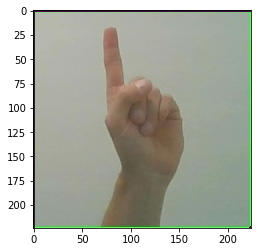

Data is initaly structured in blocks
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 

In [128]:
def load_zipped_images(zipfile):
    np.random.seed(9001)
    archive = ZipFile(zipfile, 'r')
    image_paths=archive.namelist()
    i=0
    labels=[]
    for entry in archive.infolist():
        if entry.filename[-4:]=='.jpg':
            with archive.open(entry) as file:
                img = Image.open(file)
                img2 = np.array(img)
                img3 = img2 + int(np.random.random()*100-50)
                np.clip(img3, 0, 255,out=img3)
                img3 = img3/255.
                data[i, :, :, :] = img3
                label_split = entry.filename.split('/')#[7:13]
                labels.append(label_split[1])
                i+=1

    return data, labels
from zipfile import ZipFile
from PIL import Image

archive = ZipFile("./handTracking/Images.zip", 'r')
image_data = archive.read('Images/Hand_1/Hand_14.jpg')

plt.imshow(data[1,:,:])
plt.show()

#data, labels = load_zipped_images("./handTracking/Images.zip")
data, data_labels = load_zipped_images("./handTracking/Images.zip")#
eval_data, eval_labels = load_zipped_images("./handTracking/EvaluationImages.zip")# load_images("./handTracking/EvaluationImages/",200)
# Convert labels from strings to numbers
le = preprocessing.LabelEncoder()
le.fit(data_labels)
conv_labels = le.transform(data_labels) 
conv_labels_eval = le.transform(eval_labels)


# Delete images that are just zeros
data = data[0:len(conv_labels), :, :, :]
eval_data = eval_data[0:len(conv_labels_eval), :, :, :]
print('Data is initaly structured in blocks')
print(conv_labels)
# Shuffle the data
conv_labels, data = shuffle(conv_labels, data)
conv_labels_eval, eval_data = shuffle(conv_labels_eval, eval_data)
print('Data after shuffeling')
print(conv_labels)

In [65]:
resp = urlopen("http://www.test.com/file.zip")
zipfile = ZipFile(BytesIO(resp.read()))

85800

In [81]:
from io import StringIO

In [121]:
A="./handTracking/EvaluationImages.zip"

In [124]:
A.split("/")

['.', 'handTracking', 'EvaluationImages.zip']